    - Originally created by Sanmay
    - I just cleaned it up a bit

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import random
from functools import reduce
import itertools
from collections import defaultdict
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

## Helper functions for making the datasets

In [2]:
def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])
    return f

def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    return plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

def plot_errors(results_dict, title):
    markers = itertools.cycle(('+', 'x', 'o'))

    plt.title('{}'.format(title))

    for label, result in sorted(results_dict.items()):
        plt.plot(result, marker=next(markers), label=label)
        plt.ylabel('dice_coef')
        plt.xlabel('epoch')
        plt.legend(loc=3, bbox_to_anchor=(1, 0))

    plt.show()

def masks_to_colorimg(masks):
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)

## Generating functions for different shapes inside the image

In [3]:
def generate_random_data(height, width, count):
    x, y = zip(*[generate_img_and_mask(height, width) for i in range(0, count)])

    X = np.asarray(x) * 255
    X = X.repeat(3, axis=1).transpose([0, 2, 3, 1]).astype(np.uint8)
    Y = np.asarray(y)

    return X, Y

def generate_img_and_mask(height, width):
    shape = (height, width)

    triangle_location = get_random_location(*shape)
    circle_location1 = get_random_location(*shape, zoom=0.7)
    circle_location2 = get_random_location(*shape, zoom=0.5)
    mesh_location = get_random_location(*shape)
    square_location = get_random_location(*shape, zoom=0.8)
    plus_location = get_random_location(*shape, zoom=1.2)

    # Create input image
    arr = np.zeros(shape, dtype=bool)
    arr = add_triangle(arr, *triangle_location)
    arr = add_circle(arr, *circle_location1)
    arr = add_circle(arr, *circle_location2, fill=True)
    arr = add_mesh_square(arr, *mesh_location)
    arr = add_filled_square(arr, *square_location)
    arr = add_plus(arr, *plus_location)
    arr = np.reshape(arr, (1, height, width)).astype(np.float32)

    # Create target masks
    masks = np.asarray([
        add_filled_square(np.zeros(shape, dtype=bool), *square_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location2, fill=True),
        add_triangle(np.zeros(shape, dtype=bool), *triangle_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location1),
         add_filled_square(np.zeros(shape, dtype=bool), *mesh_location),
        # add_mesh_square(np.zeros(shape, dtype=bool), *mesh_location),
        add_plus(np.zeros(shape, dtype=bool), *plus_location)
    ]).astype(np.float32)

    return arr, masks

def add_square(arr, x, y, size):
    s = int(size / 2)
    arr[x-s,y-s:y+s] = True
    arr[x+s,y-s:y+s] = True
    arr[x-s:x+s,y-s] = True
    arr[x-s:x+s,y+s] = True

    return arr

def add_filled_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, yy > y - s, yy < y + s]))

def logical_and(arrays):
    new_array = np.ones(arrays[0].shape, dtype=bool)
    for a in arrays:
        new_array = np.logical_and(new_array, a)

    return new_array

def add_mesh_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, xx % 2 == 1, yy > y - s, yy < y + s, yy % 2 == 1]))

def add_triangle(arr, x, y, size):
    s = int(size / 2)

    triangle = np.tril(np.ones((size, size), dtype=bool))

    arr[x-s:x-s+triangle.shape[0],y-s:y-s+triangle.shape[1]] = triangle

    return arr

def add_circle(arr, x, y, size, fill=False):
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    circle = np.sqrt((xx - x) ** 2 + (yy - y) ** 2)
    new_arr = np.logical_or(arr, np.logical_and(circle < size, circle >= size * 0.7 if not fill else True))

    return new_arr

def add_plus(arr, x, y, size):
    s = int(size / 2)
    arr[x-1:x+1,y-s:y+s] = True
    arr[x-s:x+s,y-1:y+1] = True

    return arr

def get_random_location(width, height, zoom=1.0):
    x = int(width * random.uniform(0.1, 0.9))
    y = int(height * random.uniform(0.1, 0.9))

    size = int(min(width, height) * random.uniform(0.06, 0.12) * zoom)

    return (x, y, size)

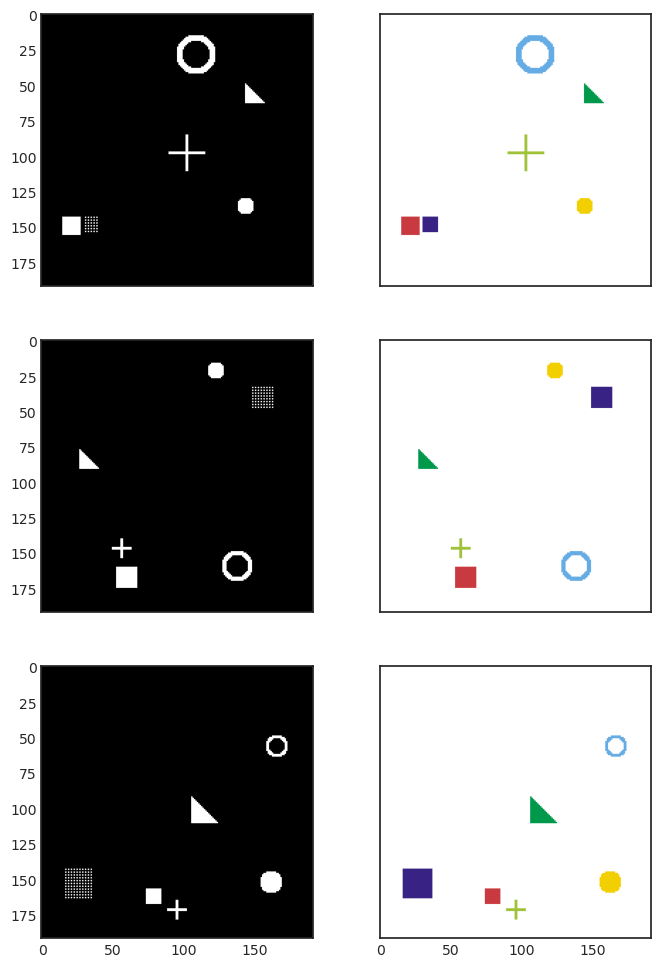

In [4]:
# Generate some random images
input_images, target_masks = generate_random_data(192, 192, count=3)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask (Ground-truth)
with plt.style.context('seaborn-white'):
    plot_side_by_side([input_images_rgb, target_masks_rgb])
    plt.show()

## Creating the custom dataset object

In [5]:
class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = generate_random_data(192, 192, count=count)        
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask  = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return image, mask

In [33]:
# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_ds = SimDataset(2000, transform = trans)
val_ds   = SimDataset(400, transform = trans)

In [34]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl   = DataLoader(val_ds, batch_size=200, shuffle=False, num_workers=0)

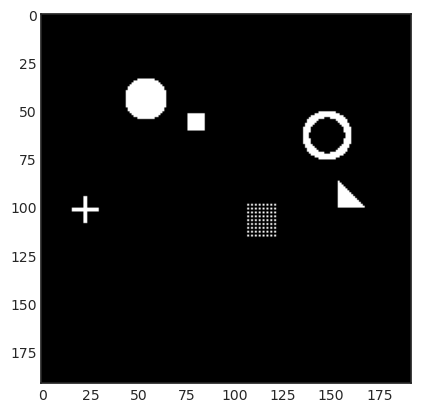

In [35]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(train_dl))

with plt.style.context('seaborn-white'):
    plt.imshow(reverse_transform(inputs[3]))
    plt.show()

## The model

In [36]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   

        x = self.dconv_up1(x)
        
        out = self.conv_last(x)

        return out

In [37]:
upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

In [38]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(6)
model = model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Define the loss function

In [39]:
inputs, masks = next(iter(train_dl))
model = UNet(6)
output = model(inputs)

In [40]:
inputs.shape, masks.shape, output.shape

(torch.Size([32, 3, 192, 192]),
 torch.Size([32, 6, 192, 192]),
 torch.Size([32, 6, 192, 192]))

In [41]:
del model; del inputs; del masks;

# The loss function

- Smooth is introduced for stability

dice loss = $2 \times \frac{\textrm{intersection} + smooth}{\textrm{union} + smooth}$

In [42]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    return loss, bce, dice

# Training

In [43]:
def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25, return_dict=None):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    if return_dict is None:
        return_dict = {
            'train': {'bce': [], 'dice': [], 'loss': []},
            'val': {'bce': [], 'dice': [], 'loss': []},
            'lrs': []
        }

    for epoch in range(num_epochs):

        # training
        metrics = defaultdict(float)
        model.train()  # Set model to training mode
        for inputs, labels in tqdm(train_dl):

            # to cuda if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss, bce, dice = calc_loss(outputs, labels, metrics)

            loss.backward()
            optimizer.step()

            # storing loss every step
            return_dict['train']['bce'].append(bce.item())
            return_dict['train']['dice'].append(dice.item())
            return_dict['train']['loss'].append(loss.item())


        # validation
        metrics = defaultdict(float)
        model.eval()  # Set model to evaluation mode
        loss_, bce_, dice_ = 0, 0, 0
        for iter_val, (inputs, labels) in enumerate(val_dl):

            # to cuda if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                loss, bce, dice = calc_loss(outputs, labels, metrics)

                loss_ += loss.item()
                bce_ += bce.item()
                dice_ += dice.item()

        # storing loss every epoch            
        return_dict['val']['bce'].append(bce_ / iter_val)
        return_dict['val']['dice'].append(dice_ / iter_val)
        return_dict['val']['loss'].append(loss_ / iter_val)

        # deep copy the model
        if loss_ < best_loss:
            best_loss = loss_
            best_model_wts = copy.deepcopy(model.state_dict())


        # store the changing lrs, so that we can look at them later
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']

        return_dict['lrs'].append(current_lr)

        print(f'Epoch {epoch + 1}/{num_epochs} (lr: {current_lr:.4f})-> dice: {dice_ / iter_val:.4f}, bce: {bce_ / iter_val:.4f}, loss: {loss_ / iter_val:.4f}')

        # update learning rate
        scheduler.step()

    return best_model_wts, return_dict

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### New thing

- Learning rate scheduler

In [45]:
num_class = 6

model = UNet(num_class).to(device)

optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)
lr_sch = lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.9)

best_model_wts, return_dict = train_model(model, optimizer_ft, lr_sch, num_epochs=10)

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/10 (lr: 0.0010)-> dice: 1.1852 - bce: 0.0818 - loss: 0.6335


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/10 (lr: 0.0009)-> dice: 0.6649 - bce: 0.0428 - loss: 0.3539


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/10 (lr: 0.0008)-> dice: 0.3289 - bce: 0.0217 - loss: 0.1753


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/10 (lr: 0.0007)-> dice: 0.1493 - bce: 0.0087 - loss: 0.0790


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/10 (lr: 0.0007)-> dice: 0.0900 - bce: 0.0055 - loss: 0.0477


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/10 (lr: 0.0006)-> dice: 0.0770 - bce: 0.0052 - loss: 0.0411


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/10 (lr: 0.0005)-> dice: 0.0746 - bce: 0.0045 - loss: 0.0396


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/10 (lr: 0.0005)-> dice: 0.0696 - bce: 0.0043 - loss: 0.0370


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/10 (lr: 0.0004)-> dice: 0.0661 - bce: 0.0035 - loss: 0.0348


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/10 (lr: 0.0004)-> dice: 0.0625 - bce: 0.0040 - loss: 0.0332


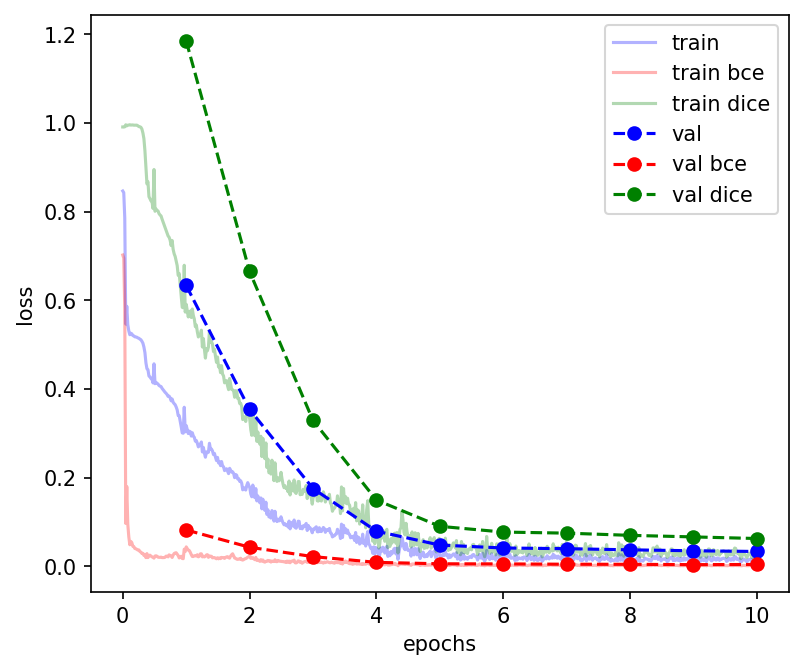

In [46]:
fig = plt.figure(figsize=(6, 5), dpi=150)

ax = fig.add_subplot(1, 1, 1)

n_epochs = len(return_dict['val']['loss'])
xs = np.linspace(0, n_epochs, len(return_dict['train']['loss']))

ax.plot(xs, return_dict['train']['loss'], label='train', c='b', alpha=0.3)
ax.plot(xs, return_dict['train']['bce'], label='train bce', c='r', alpha=0.3)
ax.plot(xs, return_dict['train']['dice'], label='train dice', c='g', alpha=0.3)

xs = np.arange(1, n_epochs + 1)
ax.plot(xs, return_dict['val']['loss'], label='val', c='b', linestyle='--', marker='o')
ax.plot(xs, return_dict['val']['bce'], label='val bce', c='r', linestyle='--', marker='o')
ax.plot(xs, return_dict['val']['dice'], label='val dice', c='g', linestyle='--', marker='o')

ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

plt.show()

(4, 6, 192, 192)


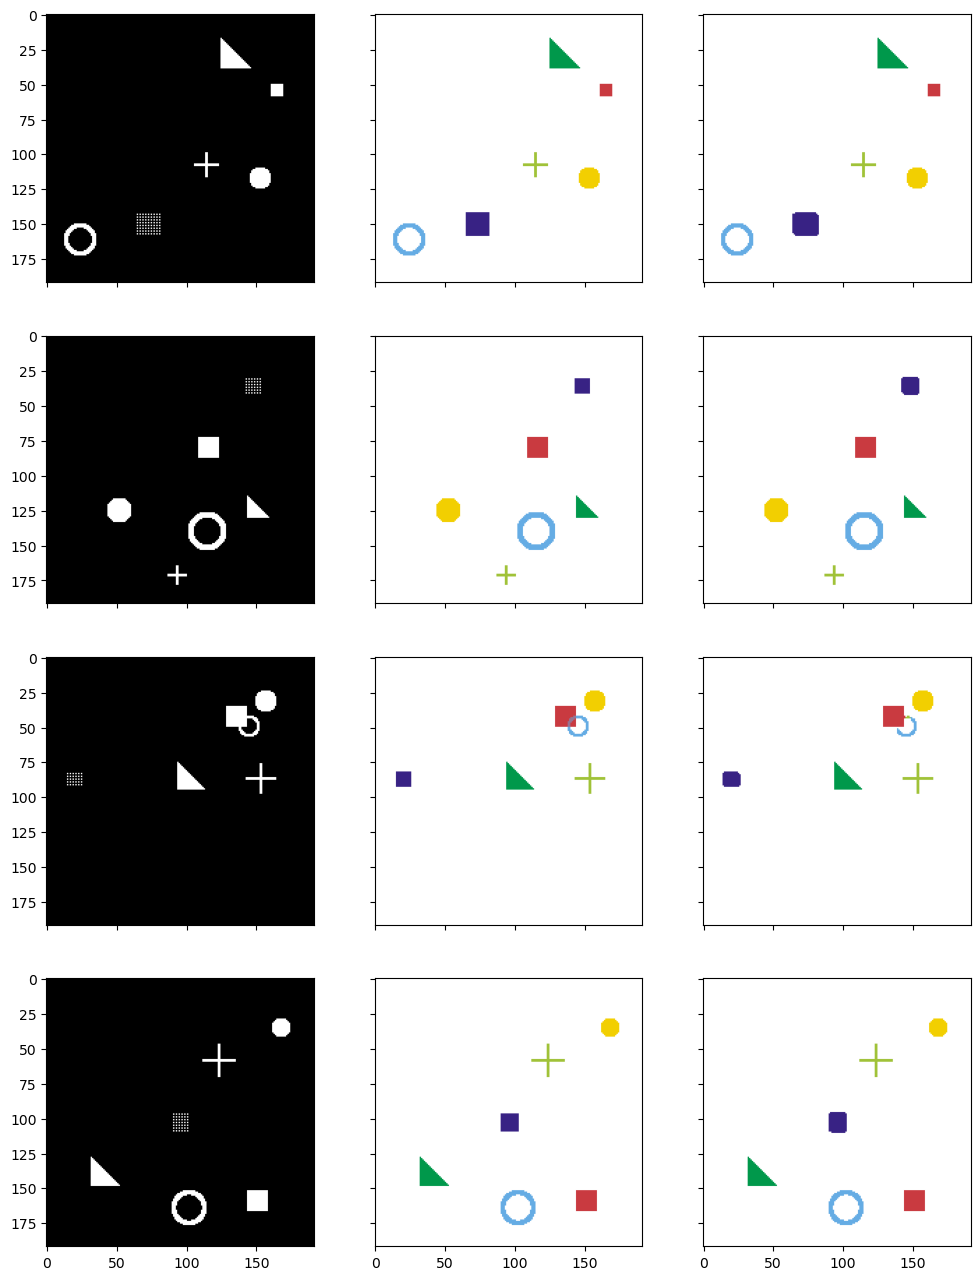

In [47]:
model = UNet(num_class).to(device)
model.load_state_dict(best_model_wts)
model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(4, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.detach().cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [masks_to_colorimg(x) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])
plt.show()

### The learning rate

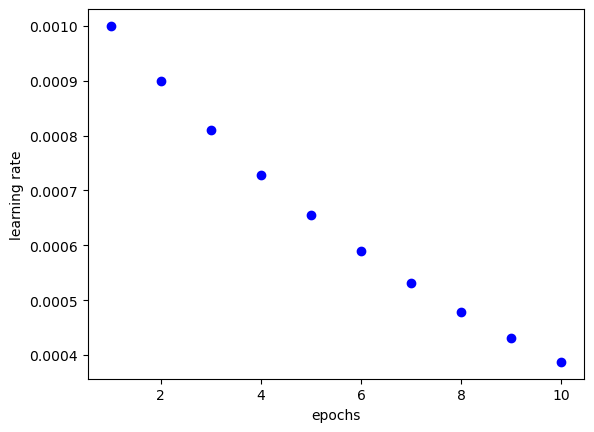

In [48]:
lrs = return_dict['lrs']
xs = np.arange(1, len(lrs) + 1)

plt.scatter(xs, lrs, label='learning rate', c='b', marker='o')
plt.xlabel('epochs')
plt.ylabel('learning rate')
plt.show()